In [19]:
import os
import pathlib
import json
import numpy as np
from tqdm import tqdm

def find_data_dirs(base_folder, include_str):
    """
    Finds all directories within `base_folder` that include `include_str` in their name.
    """
    base_folder = pathlib.Path(base_folder)
    data_dirs = [d for d in base_folder.iterdir() if d.is_dir() and include_str in str(d)]
    return data_dirs

def merge_npz_files_dynamic(base_folder, include_str, output_dir):
    """
    Finds and merges all datasets in `base_folder` that contain `include_str` in their paths.
    Saves the merged dataset to `output_dir`.
    """
    # Find directories containing the datasets
    data_dirs = find_data_dirs(base_folder, include_str)

    # Collect paths for all npz and metadata files
    npz_files = []
    meta_files = []
    for data_dir in data_dirs:
        npz_file = data_dir / "trajectories.npz"
        meta_file = data_dir / "system_meta.json"
        if npz_file.exists() and meta_file.exists():
            npz_files.append(npz_file)
            meta_files.append(meta_file)
        else:
            print(f"Skipping: {data_dir} (missing npz or metadata)")

    # Merge the datasets
    merge_npz_files(npz_files, meta_files, output_dir)

def merge_npz_files(npz_files, meta_files, output_dir):
    """
    Merge multiple npz files into one, along with their metadata.

    Args:
        npz_files (list of str): List of paths to the npz files to merge.
        meta_files (list of str): List of paths to the corresponding metadata JSON files.
        output_dir (str): Directory to save the merged npz and metadata files.
    """
    merged_data = {}
    merged_metadata = {
        "system": [],
        "metadata": [],
        "trajectories": []
    }
    system_offset = 0

    # Process each file
    for npz_file, meta_file in zip(npz_files, meta_files):
        # Load the npz file and metadata
        npz_data = np.load(npz_file)
        with open(meta_file, "r", encoding="utf8") as f:
            meta = json.load(f)
        
        # Adjust metadata for merging
        for trajectory_meta in meta["trajectories"]:
            trajectory_meta["name"] = f"system_{system_offset}_{trajectory_meta['name']}"
            merged_metadata["trajectories"].append(trajectory_meta)

        merged_metadata["system"].append(meta["system"])
        merged_metadata["metadata"].append(meta["metadata"])

        # Merge trajectory data
        for key in npz_data.files:
            if key not in merged_data:
                merged_data[key] = []
            merged_data[key].append(npz_data[key])

        system_offset += 1

    # Concatenate all trajectory arrays along the first axis (time/sequence dimension)
    for key in merged_data:
        merged_data[key] = np.stack(merged_data[key], axis=0)

    # Save merged data
    output_dir = pathlib.Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    merged_npz_path = output_dir / "trajectories.npz"
    np.savez(merged_npz_path, **merged_data)
    
    merged_meta_path = output_dir / "system_meta.json"
    with open(merged_meta_path, "w", encoding="utf8") as f:
        json.dump(merged_metadata, f, indent=4)
    
    print(f"Merged data saved to: {output_dir}")
    print(f"Total Datasets merged: {system_offset}")


In [20]:
# Usage example
kind ='active'
include_str = "eval"  # Include string to filter folders

base_folder = f"/home/aristotelis/Git/nn-benchmark/spring_mesh_data/{kind}/run/data_gen"
output_dir = f"/home/aristotelis/Git/nn-benchmark/merged_{kind}_{include_str}_dataset"

merge_npz_files_dynamic(base_folder, include_str, output_dir)

Merged data saved to: /home/aristotelis/Git/nn-benchmark/merged_active_eval_dataset
Total Datasets merged: 10


In [21]:
import json
import pathlib
import torch
from torch.utils.data import Dataset

class MergedTrajectoryDataset(Dataset):
    """Returns batches of full trajectories from a merged dataset, including sys_id.
    dataset[idx] -> a set of snapshots for a full trajectory and its system ID."""

    def __init__(self, data_dir, seq_len: int = 1, stride: int = 1):
        super().__init__()
        data_dir = pathlib.Path(data_dir)

        self.seq_len = seq_len
        self.stride = stride

        # Load metadata
        with open(data_dir / "system_meta.json", "r", encoding="utf8") as meta_file:
            metadata = json.load(meta_file)
        self.systems = metadata["system"]
        self.system_metadata = metadata["metadata"]
        self._trajectory_meta = metadata["trajectories"]
        self._npz_file = np.load(data_dir / "trajectories.npz")
        
        self._linearize = True

    def linearize(self, arr):
        if not isinstance(arr, torch.Tensor) or not self._linearize:
            return arr
        num_steps = arr.shape[0]
        if arr.dim() >= 3:
            return arr.flatten(start_dim=2).transpose(1, 2).reshape(num_steps, -1)
        elif arr.dim() == 2:
            return arr.T.reshape(num_steps, -1)

        return arr

    def _extract_seq_data(self, array):
        """Extracts sequence array from the dataset."""
        if array.dim() == 1:
            array = array.unsqueeze(1)
            
        array = self.linearize(array)

        timesteps = array.shape[0]
        seq_list = []
        for i in range(0, timesteps - self.seq_len + 1, self.stride):
            seq_list.append(array[i:i+self.seq_len,:])

        return torch.stack(seq_list, dim=1)

    def __getitem__(self, idx):
        meta = self._trajectory_meta[idx]
        name = meta["name"]
        dt = torch.tensor(meta["time_step_size"], dtype=torch.float32)

        # Extract system ID from the trajectory name (assumes "system_X_" prefix)
        sys_id = torch.tensor(int(name.split('_')[1]), dtype=torch.int32)

        # Load arrays
        p = torch.from_numpy(self._npz_file[meta["field_keys"]["p"]])[idx,:-1,:,:]
        q = torch.from_numpy(self._npz_file[meta["field_keys"]["q"]])[idx,:-1,:,:]
        p_next = torch.from_numpy(self._npz_file[meta["field_keys"]["p"]])[idx,1:,:,:]
        q_next = torch.from_numpy(self._npz_file[meta["field_keys"]["q"]])[idx,1:,:,:]
                                                                           
        dp_dt = torch.from_numpy(self._npz_file[meta["field_keys"]["dpdt"]])[idx,:-1,:,:]
        dq_dt = torch.from_numpy(self._npz_file[meta["field_keys"]["dqdt"]])[idx,:-1,:,:]
        t = torch.from_numpy(self._npz_file[meta["field_keys"]["t"]])[idx,:-1]
        u = torch.zeros_like(t)

        if "p_noiseless" in meta["field_keys"] and "q_noiseless" in meta["field_keys"]:
            p_noiseless = torch.from_numpy(self._npz_file[meta["field_keys"]["p_noiseless"]])[idx,:-1,:,:]
            q_noiseless = torch.from_numpy(self._npz_file[meta["field_keys"]["q_noiseless"]])[idx,:-1,:,:]
        else:
            p_noiseless = p
            q_noiseless = q

        if "masses" in meta["field_keys"]:
            masses = torch.from_numpy(self._npz_file[meta["field_keys"]["masses"]][idx,:])
        else:
            num_particles = p.shape[1]
            masses = torch.ones(num_particles)

        if "edge_indices" in meta["field_keys"]:
            edge_index = torch.from_numpy(self._npz_file[meta["field_keys"]["edge_indices"]][idx,:,:])
            if edge_index.shape[0] != 2:
                edge_index = edge_index.T
        else:
            edge_index = torch.tensor([])

        if "vertices" in meta["field_keys"]:
            vertices = torch.from_numpy(self._npz_file[meta["field_keys"]["vertices"]][idx,:,:])
        else:
            vertices = torch.tensor([])

        if "fixed_mask_p" in meta["field_keys"]:
            fixed_mask_p = torch.from_numpy(np.expand_dims(self._npz_file[meta["field_keys"]["fixed_mask_p"]][idx,:,:], 0))
        else:
            fixed_mask_p = torch.tensor([[]])
        if "fixed_mask_q" in meta["field_keys"]:
            fixed_mask_q = torch.from_numpy(np.expand_dims(self._npz_file[meta["field_keys"]["fixed_mask_q"]][idx,:,:], 0))
        else:
            fixed_mask_q = torch.tensor([[]])
        if "extra_fixed_mask" in meta["field_keys"]:
            extra_fixed_mask = torch.from_numpy(np.expand_dims(self._npz_file[meta["field_keys"]["extra_fixed_mask"]][idx,:], 0))
        else:
            extra_fixed_mask = torch.tensor([[]])
        if "enumerated_fixed_mask" in meta["field_keys"]:
            static_nodes = torch.from_numpy(np.expand_dims(self._npz_file[meta["field_keys"]["enumerated_fixed_mask"]][idx,:], 0))
        else:
            static_nodes = torch.tensor([[]])

        q = self._extract_seq_data(q)
        p = self._extract_seq_data(p)
        q_next = self._extract_seq_data(q_next)
        p_next = self._extract_seq_data(p_next)
        u = self._extract_seq_data(u)
        dq_dt=self._extract_seq_data(dq_dt)
        dp_dt=self._extract_seq_data(dp_dt)
        q_noiseless=self._extract_seq_data(q_noiseless)
        p_noiseless=self._extract_seq_data(p_noiseless)
        t = self._extract_seq_data(t)

        return {
            "name": name,
            "trajectory_meta": meta,
            "q": q if self.seq_len > 1 else q.squeeze(0),
            "p": p if self.seq_len > 1 else p.squeeze(0),
            "q_next": q_next if self.seq_len > 1 else q_next.squeeze(0),
            "p_next": p_next if self.seq_len > 1 else p_next.squeeze(0),
            "u": u if self.seq_len > 1 else u.squeeze(0),
            "dq_dt": dq_dt if self.seq_len > 1 else dq_dt.squeeze(0),
            "dp_dt": dp_dt if self.seq_len > 1 else dp_dt.squeeze(0),
            "dt": dt,
            "t": t if self.seq_len > 1 else t.squeeze(0),
            "q_noiseless": q_noiseless if self.seq_len > 1 else q_noiseless.squeeze(0),
            "p_noiseless": p_noiseless if self.seq_len > 1 else p_noiseless.squeeze(0),
            "masses": masses,
            "edge_index": edge_index,
            "vertices": vertices,
            "fixed_mask_q": self.linearize(fixed_mask_q),
            "fixed_mask_p": self.linearize(fixed_mask_p),
            "extra_fixed_mask": self.linearize(extra_fixed_mask),
            "static_nodes": self.linearize(static_nodes),
            "sys_id": sys_id  # New output
        }

    def __len__(self):
        return len(self._trajectory_meta)


In [22]:
import torch
from torch.utils.data import DataLoader

# Initialize the dataset
data_dir = f"/home/aristotelis/Git/nn-benchmark/merged_active_{include_str}_dataset"  # Replace with the actual path to the merged dataset
seq_len = 1  # Adjust as needed for the sequence length
stride = 1   # Adjust as needed for the stride

# Initialize the dataset
dataset = MergedTrajectoryDataset(data_dir, seq_len=seq_len, stride=stride)
print(f"Dataset's Length: {len(dataset)}")

# Wrap it in a DataLoader to manage batching
batch_size = 10  # Number of trajectories per batch
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Fetch the first batch
first_batch = next(iter(dataloader))

# Print out the details of the first batch
print("First Batch Details:")
print(f"Trajectory Name: {first_batch['name'][0]}")
print(f"System ID (sys_id): {first_batch['sys_id'][0].item()}")
print(f"q Shape: {first_batch['q'].shape}")
print(f"p Shape: {first_batch['p'].shape}")
print(f"q_next Shape: {first_batch['q_next'].shape}")
print(f"p_next Shape: {first_batch['p_next'].shape}")
print(f"u Shape: {first_batch['u'].shape}")
print(f"dq_dt Shape: {first_batch['dq_dt'].shape}")
print(f"dp_dt Shape: {first_batch['dp_dt'].shape}")
print(f"t Shape: {first_batch['t'].shape}")
print(f"q_noiseless Shape: {first_batch['q_noiseless'].shape}")
print(f"p_noiseless Shape: {first_batch['p_noiseless'].shape}")
print(f"Masses Shape: {first_batch['masses'].shape}")
print(f"Edge Index Shape: {first_batch['edge_index'].shape}")
print(f"Vertices Shape: {first_batch['vertices'].shape}")
print(f"Fixed Mask q Shape: {first_batch['fixed_mask_q'].shape}")
print(f"Fixed Mask p Shape: {first_batch['fixed_mask_p'].shape}")
print(f"Extra Fixed Mask Shape: {first_batch['extra_fixed_mask'].shape}")
print(f"Static Nodes Shape: {first_batch['static_nodes'].shape}")

# Optional: Visualize or debug specific parts of the batch
print("\nExample Values:")
print(f"q (First Few Steps): {first_batch['q'][0, :5, :5]}")  # Show first few steps of q
# print(f"sys_id: {first_batch['sys_id'][0].item()}")
print(f"Vertices Shape: {first_batch['vertices']}")

Dataset's Length: 10
First Batch Details:
Trajectory Name: system_0_traj_00000
System ID (sys_id): 0
q Shape: torch.Size([10, 1499, 200])
p Shape: torch.Size([10, 1499, 200])
q_next Shape: torch.Size([10, 1499, 200])
p_next Shape: torch.Size([10, 1499, 200])
u Shape: torch.Size([10, 1499, 1])
dq_dt Shape: torch.Size([10, 1499, 200])
dp_dt Shape: torch.Size([10, 1499, 200])
t Shape: torch.Size([10, 1499, 1])
q_noiseless Shape: torch.Size([10, 1499, 200])
p_noiseless Shape: torch.Size([10, 1499, 200])
Masses Shape: torch.Size([10, 100])
Edge Index Shape: torch.Size([10, 2, 684])
Vertices Shape: torch.Size([10, 0])
Fixed Mask q Shape: torch.Size([10, 1, 200])
Fixed Mask p Shape: torch.Size([10, 1, 200])
Extra Fixed Mask Shape: torch.Size([10, 1, 100])
Static Nodes Shape: torch.Size([10, 1, 0])

Example Values:
q (First Few Steps): tensor([[ 0.5517,  0.2683, -0.7536,  0.1334,  0.3420],
        [ 0.4617,  0.4250, -0.6473,  0.1427,  0.3734],
        [ 0.4011,  0.3459, -0.5449,  0.1400,  0.39

In [23]:
import matplotlib.pyplot as plt
import torch
def plot_trajectory(t, q_clean, q_noisy, p_noisy, p_clean, sys_idx, state_idxs):


    # Calculate the noise by subtracting the clean signal from the noisy signal
    noise_q = q_noisy[sys_idx,:,:] - q_clean[sys_idx,:,:]
    # Calculate the power of the clean signal and noise
    signal_power_q = torch.mean(q_clean[sys_idx,:,:] ** 2)
    noise_power_q = torch.mean(noise_q ** 2)
    # Calculate the SNR
    snr_q = 10 * torch.log10(signal_power_q / noise_power_q)
    print(f"SNR q: {snr_q}")

    # Calculate the noise by subtracting the clean signal from the noisy signal
    noise_p = p_noisy[sys_idx,:,:] - p_clean[sys_idx,:,:]
    # Calculate the power of the clean signal and noise
    signal_power_p = torch.mean(p_clean[sys_idx,:,:] ** 2)
    noise_power_p = torch.mean(noise_p ** 2)
    # Calculate the SNR
    snr_p = 10 * torch.log10(signal_power_p / noise_power_p)
    print(f"SNR p: {snr_p}")

    plt.figure()
    for i, idx in enumerate(state_idxs):

        plt.subplot(len(state_idxs), 2, 2*i+1)
        plt.plot(t[sys_idx,:,:], q_noisy[sys_idx,:,idx], label = 'Noisy' if i == 0 else '', color='black', alpha=0.5)
        plt.plot(t[sys_idx,:,:], q_clean[sys_idx,:,idx], label = 'Clean' if i == 0 else '',color='red')
        plt.xlabel('Time [s]')
        plt.ylabel('q [m]')

        plt.subplot(len(state_idxs), 2, 2*i+2)
        plt.plot(t[sys_idx,:,:], p_noisy[sys_idx,:,idx], label = 'Noisy' if i == 0 else '', color='black', alpha=0.5)
        plt.plot(t[sys_idx,:,:], p_clean[sys_idx,:,idx], label = 'Clean' if i == 0 else '', color='red')
        plt.xlabel('Time [s]')
        plt.ylabel('p [kg m/s]')

    plt.tight_layout()
    plt.show()

SNR q: 38.95018713314154
SNR p: 25.758481886442354


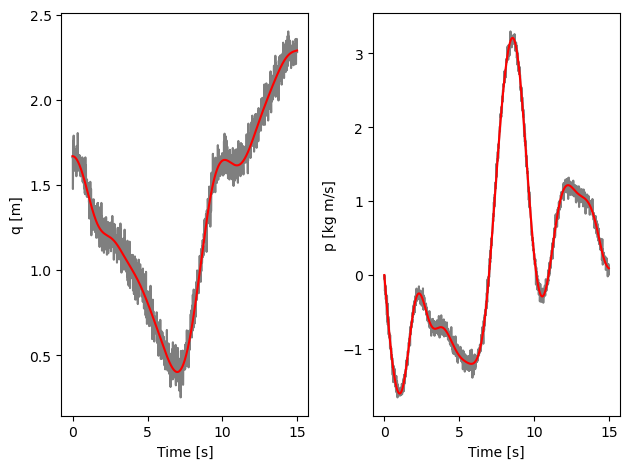

In [24]:
sys_idx = 1
state_idxs = torch.arange(10, 11)
t = first_batch['t']
q_clean = first_batch['q_noiseless']
q_noisy = first_batch['q']
p_noisy = first_batch['p']
p_clean = first_batch['p_noiseless']

plot_trajectory(t, q_clean, q_noisy, p_noisy, p_clean, sys_idx, state_idxs)